Best score: 0.9968141393673309
Best params: OrderedDict([('learning_rate', 0.2), ('max_depth', 10), ('max_features', 'log2'), ('min_samples_leaf', 16), ('min_samples_split', 20), ('n_estimators', 179), ('subsample', 0.5)])


['minmax_scaler.pkl']

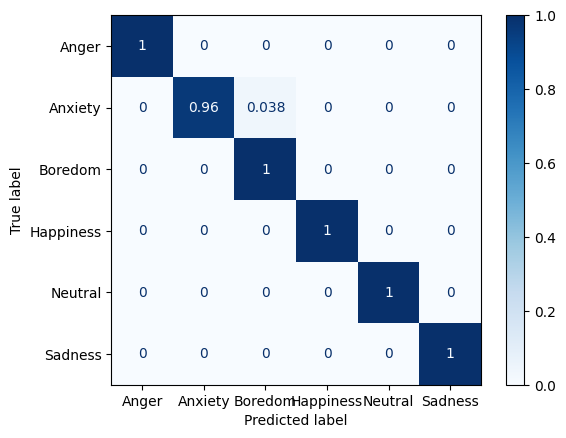

In [55]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay    
import pandas as pd
import joblib

# Carregar dados
data = pd.read_csv("dataset.csv")

data = data.drop('User_ID', axis=1)

# Colunas categóricas
categoric_columns = ['Gender', 'Platform']

# Aplicar OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categoric_data = data[categoric_columns]
data_encoded = pd.DataFrame(encoder.fit_transform(categoric_data), columns=encoder.get_feature_names_out(categoric_columns))

final_data = pd.concat([data.drop(categoric_columns, axis=1), data_encoded], axis=1)

# Colunas para normalizar
columns_to_normalize = [
    'Age',
    'Daily_Usage_Time (minutes)',
    'Posts_Per_Day',
    'Likes_Received_Per_Day',
    'Comments_Received_Per_Day',
    'Messages_Sent_Per_Day'
]

scaler = MinMaxScaler()
normalized_data = final_data.copy()
normalized_data[columns_to_normalize] = scaler.fit_transform(normalized_data[columns_to_normalize])

# Dividir dados em treino e teste
X = normalized_data.drop('Dominant_Emotion', axis=1)
y = normalized_data['Dominant_Emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Aplicar SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

# Definir espaço de busca para BayesSearchCV
param_space_gb = {
    'n_estimators': Integer(50, 300),
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20),
    'subsample': Real(0.5, 1.0),
    'max_features': Categorical(['sqrt', 'log2', None])
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Treinar o modelo usando BayesSearchCV
opt_gb = BayesSearchCV(estimator=GradientBoostingClassifier(random_state=0),
                       search_spaces=param_space_gb,
                       n_iter=50,
                       cv=cv,
                       scoring='recall_weighted',
                       n_jobs=-1,
                       random_state=0)

opt_gb.fit(X_balanced, y_balanced)

# Exibir os melhores parâmetros e pontuação
print(f'Best score: {opt_gb.best_score_}')
print(f'Best params: {opt_gb.best_params_}')

# Avaliar no conjunto de teste
y_pred = opt_gb.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Blues', display_labels=opt_gb.classes_)

# Salvar o modelo e os objetos de pré-processamento
joblib.dump(opt_gb, 'opt_gb_model.pkl')
joblib.dump(encoder, 'onehot_encoder.pkl')
joblib.dump(scaler, 'minmax_scaler.pkl')
